In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from skimage import exposure, util
import seaborn_image as isns
import scipy.io as sio
from scipy.signal import find_peaks


2024-05-04 16:57:26.337003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 16:57:26.836349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/instanton/miniconda3/lib/
2024-05-04 16:57:26.836403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/instanton/miniconda3/lib/
2024-05-04 16:57:26.836409: W tensorflow/compiler/tf2tensorrt/ut

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
def normalize(sig,amin=0,amax=1):
    if len(sig.shape) == 1:
        return amin+(amax-amin)*(sig-np.min(sig))/(np.max(sig)-np.min(sig)+1e-12)
    elif len(sig.shape) == 2:
        return amin+(amax-amin)*(sig-np.min(sig,axis=1)[:,None])/(np.max(sig,axis=1)[:,None]-np.min(sig,axis=1)[:,None]+1e-12)
def crop(image,roi):# roi:[left, bottom, width, height]
    return image[roi[1]:roi[1]+roi[3],roi[0]:roi[0]+roi[2]]
def contrast_stretch(image,perc=(0,100)):
    p_l, p_h = np.percentile(image, perc)
    return exposure.rescale_intensity(image, in_range=(p_l, p_h))
def ra(data,win=3):
    if (win%2)==0:
        raise TypeError("win must be an odd number")
    elif win==1:
        return data
    else:
        return np.mean([np.pad(data,pad_width=(w,win-w-1))[(win-1)//2:-(win-1)//2] for w in range(win)],axis=0)

In [5]:
def test_nn(nn_model,ds_h5_test,sample,roi,perc=(0,100),gamma=0.1,xlim=None,xtick_interval=None,ax=None,\
            fit=True,savemat=None,ra_win=5,show_plot=True):
    if type(ds_h5_test) == str:
        with h5py.File(ds_h5_test,'r') as hf:
            _img = hf['image'][sample,:,:]
#             y_test_NKT = decimate(hf['osa'][sample,:,1],res,axis=-1).squeeze()[:hf['osa'].shape[-2]//res]
            _true = hf['osa'][sample,:,1].squeeze()
            wavelengths = hf['osa'][0,:,0].squeeze()
#             _filelog = hf.attrs['filelog'][sample]
        _true = normalize(_true)
        _img = contrast_stretch(exposure.adjust_gamma(crop(_img,roi),gamma),perc)[None,:]
    else:
        _true = normalize(ds_h5_test['y'][:])
#         _img = contrast_stretch(ds_h5_test['x'],perc)[None,:]
        _img = contrast_stretch(exposure.adjust_gamma(ds_h5_test['x'],gamma),perc)[None,:]
        wavelengths = ds_h5_test['l'][:]
        _filelog = np.nan
    print(wavelengths.min(),wavelengths.max())
#     print(wavelengths,_true)
    _pred = nn_model.predict(_img)[0]
    _smooth = normalize(ra(_pred,ra_win))
    _loc,_ = find_peaks(_smooth,height=2.5e-1)
    if len(_loc) > 0:
        _loc = _loc[np.argmax([_smooth[_l] for _l in _loc]).flatten()]
    if fit:
        _popt, _pcov = curve_fit(gauss,xdata=wavelengths,ydata=_smooth,p0=[wavelengths[_loc][0],2],bounds=([wavelengths[_loc][0]-10,0],[wavelengths[_loc][0]+10,10]))
        print(_loc,_popt)
        print(f'peak: {_popt[0]}, FWHM: {2.355*_popt[1]}')
        _pred_fit = normalize(gauss(wavelengths,*_popt))
    print('mse:',np.mean((_true-_pred)**2))
    print('std:',np.std(_true-_pred))
    if show_plot:
        if ax == None:
            fig,ax = plt.subplots(2,1,figsize=(15,10))
            plt.subplots_adjust(hspace=0.01)
            isns.imshow(np.squeeze(_img),dx=1/1.82,units="um",robust=False,perc=(0,100),ax=ax[0],interpolation='none')
    #         ax[1].plot(wavelengths,_smooth,color='gray',lw=1,ls='--',label='predict [rolling average]')
    #         plt.plot(wavelengths,normalize(savgol_filter(_pred, 15, 3)),lw=0.75,ls='--',color='lightgray',label='predict [Savitzky-Golay filter]')
#             ax[1].plot(wavelengths,_true,color='black',label=f'true [peakX={_filelog:.2f}]')
            ax[1].plot(wavelengths,_true,color='black',marker='o')
            ax[1].plot(wavelengths,normalize(_pred),color='magenta',marker='v',lw=1,label=f'predict [peakX={float(wavelengths[_loc]):.2f}]')
            if fit:
                ax[1].plot(wavelengths,_pred_fit,color='cyan',ls='-',lw=1.2,label=f'Gauss fit [peakX={_popt[0]:.2f}]')
            ax[1].set_xlabel('wavelength [nm]')
            ax[1].set_ylabel('magnitude [normalized]')
            ax[1].legend(loc='upper right',fontsize=10)
            ax[1].grid(axis='both',which='both',color='lightgray',ls=':')
            if (type(xlim) == tuple) or (type(xlim) == list):
                ax[1].set_xlim(xlim)
                if xtick_interval != None:
                    ax[1].set_xticks(np.arange(xlim[0],xlim[1]+xtick_interval,xtick_interval))
            
            ax[1].set_title(f'MSE={np.mean((_true-normalize(_pred))**2):.3f}')
            plt.show()
        else:
            ax.plot(wavelengths,_true,color='black',label=f'true [peakX={_filelog:.2f}]')
            ax.plot(wavelengths,normalize(_pred),color='magenta',lw=1,label=f'predict [peakX={float(wavelengths[_loc]):.2f}]')
            if fit:
                ax.plot(wavelengths,_pred_fit,color='cyan',ls='-',lw=1.2,label=f'Gauss fit [peakX={_popt[0]:.2f}]')
            ax.set_xlabel('wavelength [nm]')
            ax.set_ylabel('magnitude [normalized]')
            ax.legend(loc='upper right',fontsize=10)
            ax.grid(axis='both',which='both',color='lightgray',ls=':')
            if (type(xlim) == tuple) or (type(xlim) == list):
                ax.set_xlim(xlim)
                if xtick_interval != None:
                    ax[1].set_xticks(np.arange(xlim[0],xlim[1]+xtick_interval,xtick_interval))
            ax.set_title(f'MSE={np.mean((_true-normalize(_pred))**2):.3f}')
    else:
        return np.mean((_true-_pred)**2)
    if type(savemat) == str:
        if fit:
            sio.savemat(savemat,{'wavelengths':wavelengths,'true':_true,'pred':normalize(_pred),'rollingaverage':_smooth,'gaussfit':_pred_fit})
        else:
            sio.savemat(savemat,{'wavelengths':wavelengths,'true':_true,'pred':normalize(_pred),'rollingaverage':_smooth})

 # New working model with bigger ROI (1200) and bigger strides of conv layers (March 23)


In [8]:
#load model-nafiz

size = 2000
divide_ratio = 0.9
width = 1200
perc = (1,95)
gamma = 1.0
roi = (100,185,1200,120)

model='model.h5'

# nn_model = tf.keras.models.load_model(f'{ds_dir}{info}_mvloss_model.h5',compile=False)

nn_model = tf.keras.models.load_model(model,compile=False)

793.0 796.98
1/1 [==============================] - 0s 12ms/step
mse: 0.00020698436
std: 0.014237044


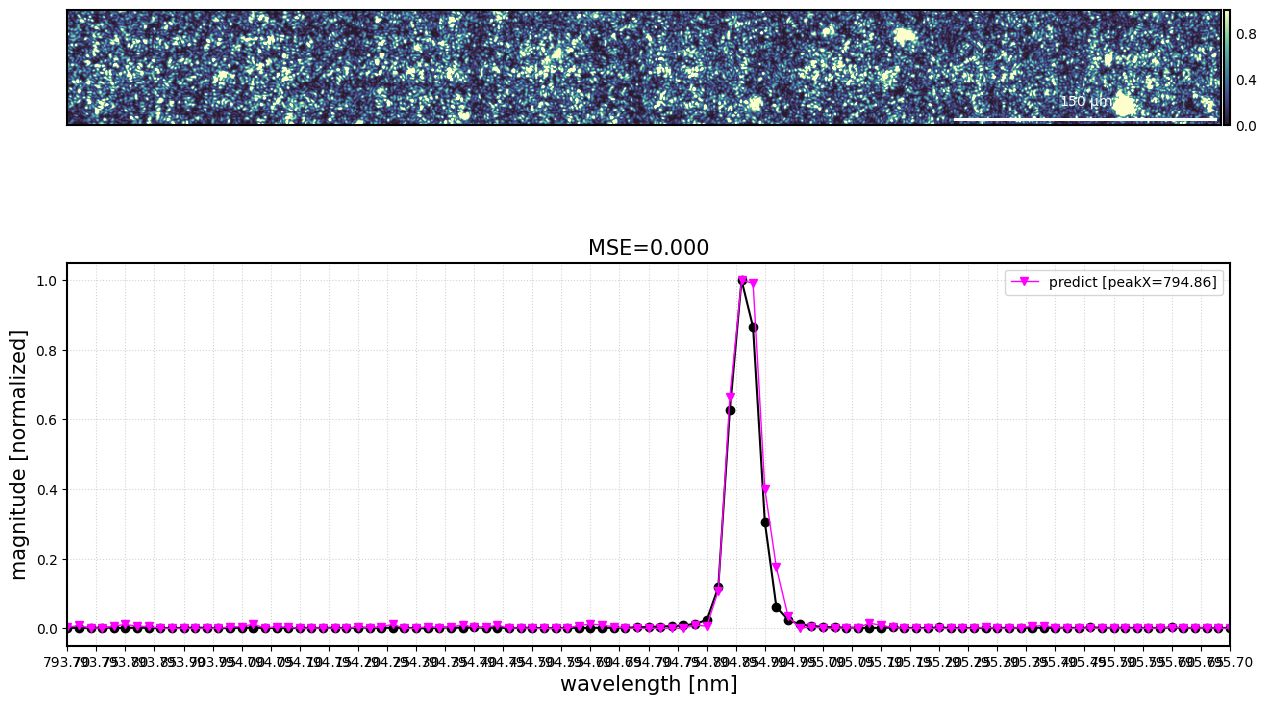

In [14]:
test_sample = 13
width = 1200
roi = (0,0,width,120)  
gamma = 1.0
xl=(793.7,795.7)

perc = (1,95)
# roi = (101,1622,width,120)

# ra_win=1
# _ax = test_nn(nn_model,'testset_100pm_rot0_05_fullroi.h5',test_sample,roi,perc=perc,gamma=gamma,fit=True)
_ax = test_nn(nn_model,'testset.h5',\
              test_sample,roi,perc=perc,gamma=gamma,xlim=xl,xtick_interval=0.05,fit=False,ra_win=1)